In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import en_core_web_lg

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.sparse import save_npz, load_npz, hstack
# from sentence_transformers import SentenceTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
## Loading the data
train_data = pd.read_csv('cleaned_featurized_train.csv')
train_labels = np.load('train_labels.npy')

test_data = pd.read_csv('cleaned_featurized_test.csv')
test_labels = np.load('test_labels.npy')

## Creating Word Vectors

### Dropping Less important features

In [4]:
# Dropping features
train_data = train_data.drop(columns=['ctc_min', 'ctc_max', 'fuzz_ratio'])
test_data = test_data.drop(columns=['ctc_min', 'ctc_max', 'fuzz_ratio'])

# Encoding questions as unicode
train_data['question1'] = train_data['question1'].apply(lambda x: str(x))
train_data['question2'] = train_data['question2'].apply(lambda x: str(x))

test_data['question1'] = test_data['question1'].apply(lambda x: str(x))
test_data['question2'] = test_data['question2'].apply(lambda x: str(x))

### TF-IDF embedding

In [5]:
# Initialize vectorizer
vectorizer = TfidfVectorizer(lowercase=False)

# Put all questions (1 and 2) into one list
questions = list(list(train_data['question1']) + list(train_data['question2']))

# Fit the vectorizer
print('Fitting')
vectorizer.fit(questions)

# Vectorizing question1
print('Vectorizing question1')
q1_vecs_tfidf_train = vectorizer.transform(train_data['question1'].values)
q1_vecs_tfidf_test = vectorizer.transform(test_data['question1'].values)

# Vectorizing question2
print('Vectorizing question2')
q2_vecs_tfidf_train = vectorizer.transform(train_data['question2'].values)
q2_vecs_tfidf_test = vectorizer.transform(test_data['question2'].values)

# Mapping terms to their IDF values
print('Mapping terms to their IDF values')
idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

print('Converting to DataFrames')
q1_tfidf_train = pd.DataFrame.sparse.from_spmatrix(q1_vecs_tfidf_train)
q2_tfidf_train = pd.DataFrame.sparse.from_spmatrix(q2_vecs_tfidf_train)

q1_tfidf_test = pd.DataFrame.sparse.from_spmatrix(q1_vecs_tfidf_test)
q2_tfidf_test = pd.DataFrame.sparse.from_spmatrix(q2_vecs_tfidf_test)

Fitting
Vectorizing question1
Vectorizing question2
Mapping terms to their IDF values
Converting to DataFrames


In [12]:
# Dropping columns
train_data = train_data.drop(columns=['question1', 'question2', 'qid1', 'qid2', 'id'])
test_data = test_data.drop(columns=['question1', 'question2', 'qid1', 'qid2', 'id'])

In [9]:
def plot_confusion_matrices(true, pred):
  # Normal confusion matrix
  conf = confusion_matrix(true, pred)
  
  # Precision matrix
  # Precision: Out of all the points predicted of class 'A', how many are actually class 'A'
  # A column in the confusion matrix represents the data points predicted as the same class
  # So we divide all data points by the sum of points in their respective columns
  precision = (conf.T / conf.sum(axis=1)).T

  # Recall matrix
  # Recall: Out of all the points which are of class 'A', how many were predicted to be of class 'A'
  # A row in the confusion matrix represents the data points of the same class
  # So we divide all data points by the sum of points in their respective rows
  recall = (conf / conf.sum(axis=0))

  # Plotting the matrices
  plt.figure(figsize=(24,6))

  # Set axes labels
  labels = ['0', '1']

  # Set colourmap
  cmap = sns.light_palette('purple')

  # Plot normal confusion matrix
  plt.subplot(1, 3, 1)
  sns.heatmap(conf, cmap=cmap, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')

  # Plot precision confusion matrix
  plt.subplot(1, 3, 2)
  sns.heatmap(precision, cmap=cmap, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Precision Matrix')

  # Plot recall confusion matrix
  plt.subplot(1, 3, 3)
  sns.heatmap(recall, cmap=cmap, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Recall Matrix')

  plt.show()

## Model 1: Only token features

In [14]:
# First, let's standardize our features. We won't be standardizing the 'last_word_eq' and 'first_word_eq'
# as these are more like a yes/no indicator
# I am not standardizing the main dataframe itself as I want to preserve the actual values if I need them later

# Initialize StandardScaler
scaler = StandardScaler()

# Train data
# Getting all columns except the two specified ones
scaled = train_data.loc[:, (train_data.columns != 'last_word_eq') & (train_data.columns != 'first_word_eq')]
scaled = scaler.fit_transform(scaled)

model_1_train = np.column_stack((scaled, train_data['last_word_eq'], train_data['first_word_eq']))

# Test data
scaled = test_data.loc[:, (test_data.columns != 'last_word_eq') & (test_data.columns != 'first_word_eq')]
scaled = scaler.transform(scaled)
model_1_test = np.column_stack((scaled, test_data['last_word_eq'], test_data['first_word_eq']))

### Random model
Let's build a random model and check our log-loss and confusion matrices. This can be a baseline for our other models.

Log-loss for a random model is: 0.88576



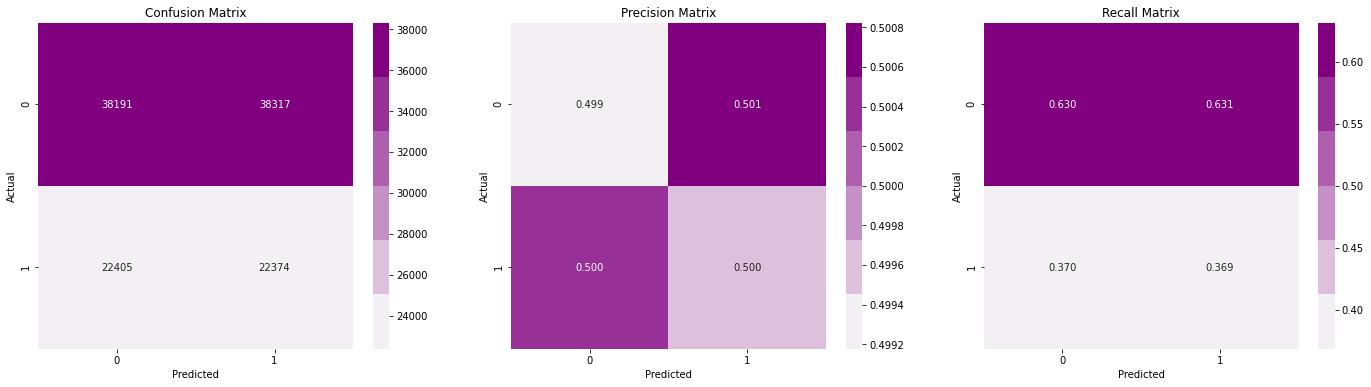

In [19]:
# Initialzing data structure to hold predicted probabilities
predicted = np.zeros((len(test_labels), 2))

for i in range(len(test_labels)):
  # Getting 2 random values
  prob = np.random.rand(1, 2)

  # Making so that both the random values sum to 1
  predicted[i] = (prob / sum(sum(prob)))[0]

# Log-loss on the positive class label
random_logloss = log_loss(test_labels, predicted[:, 1])
print('Log-loss for a random model is: {:.5f}\n'.format(random_logloss))

# Now we assign class labels 0 or 1 depending on which has higher probabilities
# This way we can create confusion matrices
predicted = np.argmax(predicted, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Logistic Regression

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.5327996414216923
Regularization: L1	alpha = 0.0001	loss: 0.5316903279968521
Regularization: L1	alpha = 0.001	loss: 0.5332076326279063
Regularization: L1	alpha = 0.01	loss: 0.5432876534547216
Regularization: L1	alpha = 0.1	loss: 0.5539014658730984
Regularization: L1	alpha = 1	loss: 0.6585278256322702
Regularization: L1	alpha = 10	loss: 0.6585278256322701

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.533080262960543
Regularization: L2	alpha = 0.0001	loss: 0.5328962715331386
Regularization: L2	alpha = 0.001	loss: 0.5324474662914369
Regularization: L2	alpha = 0.01	loss: 0.5342869967121313
Regularization: L2	alpha = 0.1	loss: 0.5445149454898532
Regularization: L2	alpha = 1	loss: 0.5543093396461529
Regularization: L2	alpha = 10	loss: 0.5567289400253889

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.5341942992329362
Regularization: ElasticNet	alpha = 0.0001	loss: 0.5320660105194793
Regulariza

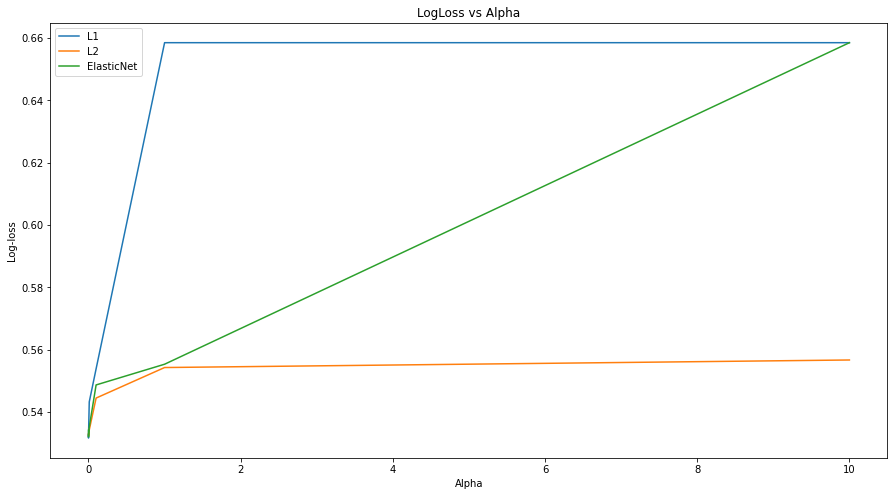

In [20]:
# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

The least logloss is from ElasticNet with a loss of 0.5320. In this case, we will go with the model which gives a lower loss and therefore proceed with the ElasticNet model.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.5330884077089723
Log loss for best alpha on test data: 0.5320660105194793




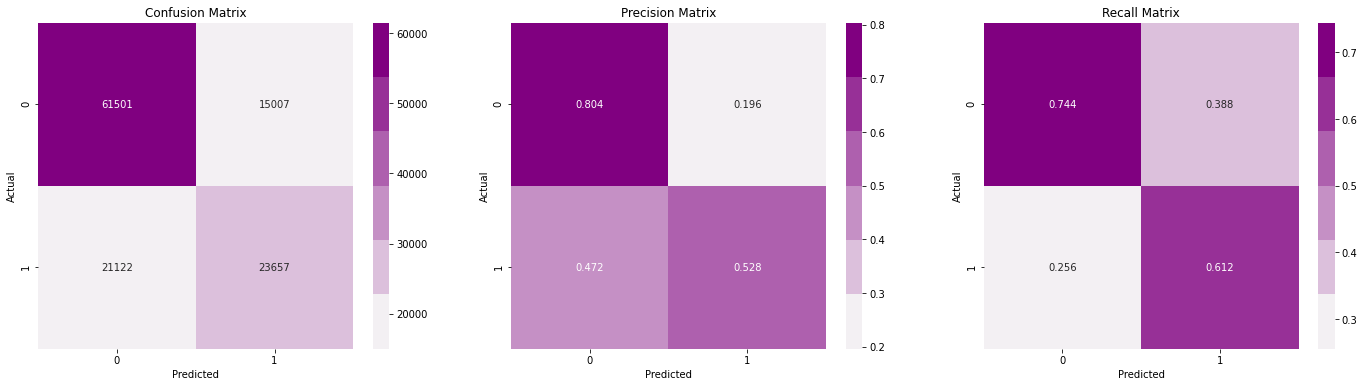

In [21]:
# Finding best alpha
best_alpha = alpha[np.argmin(elasticnet_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='log', alpha=best_alpha, penalty='elasticnet', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_1_train, train_labels)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_1_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_1_train)
predict_test = cal_clf.predict_proba(model_1_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

## Naive Bayes

### GDBT: XgBoost

#### Hyperparameter tuning

In [28]:
# First, we create the list of hyperparameters to iterate over
max_depth = [2, 4, 6]
n_estimators = [10, 100, 500]

# Initialize list to store log-loss results
result_logloss = []

# Iterating over max_depth
for depth in max_depth:
  # Initialize list to store log loss for this iteration
  logloss = []
  # Iterate over n_estimators
  for n in n_estimators:
    print('Running at depth: {}, n_estimators: {}'.format(depth, n))

    # Initialize model
    gbdt_clf = xgb.XGBClassifier(max_depth=depth, n_estimators=n, objective='binary:logistic', 
                                 verbosity = 0, n_jobs=-1, random_state=42)

    # Fitting on train data
    gbdt_clf.fit(model_1_train, train_labels)

    # Initializing calibration model
    cal_clf = CalibratedClassifierCV(gbdt_clf) 

    # Fitting calibration model
    cal_clf.fit(model_1_train, train_labels)

    # Predict on test data
    pred_prob = cal_clf.predict_proba(model_1_test)

    # Get log-loss on predictions
    loss = (log_loss(test_labels, pred_prob))
    logloss.append(loss)

  result_logloss.append(logloss)

Running at depth: 2, n_estimators: 10
Running at depth: 2, n_estimators: 100
Running at depth: 2, n_estimators: 500
Running at depth: 4, n_estimators: 10
Running at depth: 4, n_estimators: 100
Running at depth: 4, n_estimators: 500
Running at depth: 6, n_estimators: 10
Running at depth: 6, n_estimators: 100
Running at depth: 6, n_estimators: 500


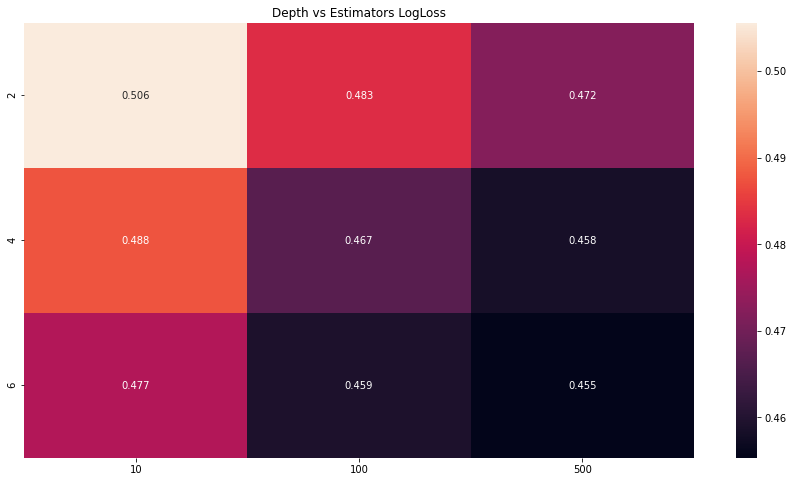

In [29]:
# Plot log loss heatmap
plt.figure(figsize=(15,8))
sns.heatmap(result_logloss, annot=True, fmt='.3f', xticklabels=n_estimators, yticklabels=max_depth)
plt.title('Depth vs Estimators LogLoss')

plt.show()

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.4620913883563629
Log loss for best alpha on test data: 0.46871549745741625




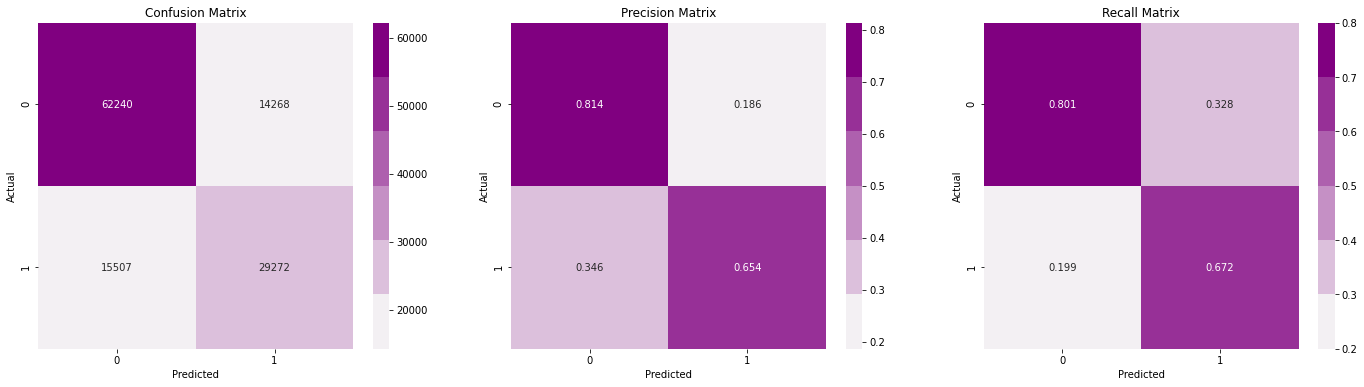

In [30]:
# Setting best hyperparameters
n_estimators=1000
max_depth=2 # Best is depth 6, use later for better results

# Initialize model
gbdt_clf = xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, objective='binary:logistic', n_jobs=-1, random_state=42)

# Fitting on train data
gbdt_clf.fit(model_1_train, train_labels)

# Initializing calibration model
cal_clf = CalibratedClassifierCV(gbdt_clf) 

# Fitting calibration model
cal_clf.fit(model_1_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_1_train)
predict_test = cal_clf.predict_proba(model_1_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

## Model 2 : TF - IDF Vectors

In [31]:
# We already loaded the train and test question pair TF-IDF sparse matrices while computing TF-IDF vectors
# Let's horizontally stack them in q1q2 order
model_2_train = hstack((q1_vecs_tfidf_train, q2_vecs_tfidf_train))
model_2_test = hstack((q1_vecs_tfidf_test, q2_vecs_tfidf_test))

### Random model
Let's build a random model and check our log-loss and confusion matrices. This can be a baseline for our other models.

Log-loss for a random model is: 0.88426



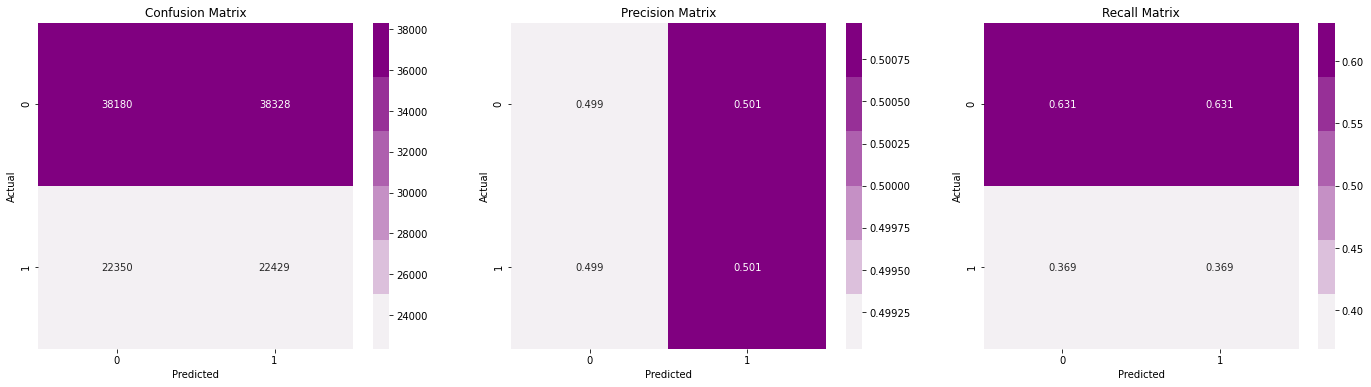

In [32]:
# Initialzing data structure to hold predicted probabilities
predicted = np.zeros((len(test_labels), 2))

for i in range(len(test_labels)):
  # Getting 2 random values
  prob = np.random.rand(1, 2)

  # Making so that both the random values sum to 1
  predicted[i] = (prob / sum(sum(prob)))[0]

# Log-loss on the positive class label
random_logloss = log_loss(test_labels, predicted[:, 1])
print('Log-loss for a random model is: {:.5f}\n'.format(random_logloss))

# Now we assign class labels 0 or 1 depending on which has higher probabilities
# This way we can create confusion matrices
predicted = np.argmax(predicted, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Logistic Regression

#### Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.5312306508902455
Regularization: L1	alpha = 0.0001	loss: 0.5786305684078805
Regularization: L1	alpha = 0.001	loss: 0.6380133181108645
Regularization: L1	alpha = 0.01	loss: 0.65852782563227
Regularization: L1	alpha = 0.1	loss: 0.6585278256322703
Regularization: L1	alpha = 1	loss: 0.6585278256322702
Regularization: L1	alpha = 10	loss: 0.6585278256322701

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.5171603243778986
Regularization: L2	alpha = 0.0001	loss: 0.5391746957586827
Regularization: L2	alpha = 0.001	loss: 0.5698180424740905
Regularization: L2	alpha = 0.01	loss: 0.5851245625855589
Regularization: L2	alpha = 0.1	loss: 0.600400616757933
Regularization: L2	alpha = 1	loss: 0.609826679432328
Regularization: L2	alpha = 10	loss: 0.6109849860690546

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.5203364376473728
Regularization: ElasticNet	alpha = 0.0001	loss: 0.5527194789845045
Regularizatio

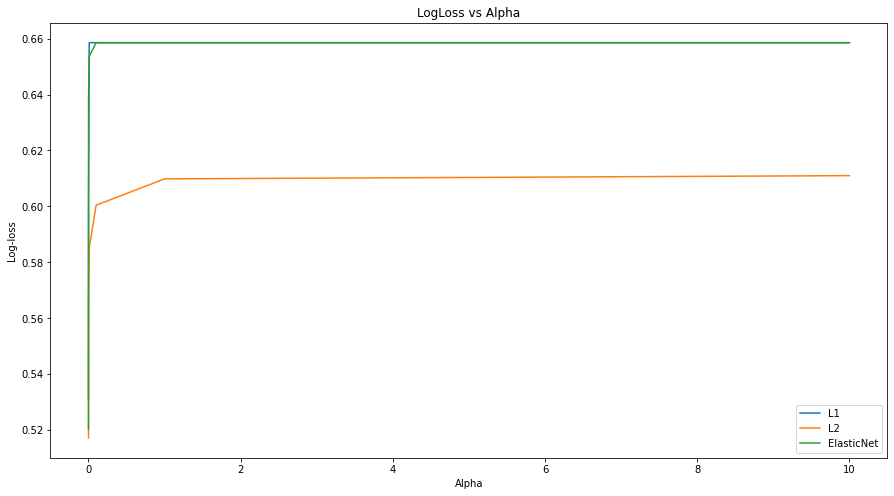

In [33]:
# Note: Hyperparamter tuning is easier with GridSearchCV/RandomSearchCV but its more fun this way
# and is it even worth it if you're not having fun :)

# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_2_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_2_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_2_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_2_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_2_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_2_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

The least logloss is from L2 with a loss of 0.535. This is higher than our previous two models. Nevertheless, in this case, we will go with the model which gives a lower loss and therefore proceed with the L2 model.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.4803686999498436
Log loss for best alpha on test data: 0.5171603243778986




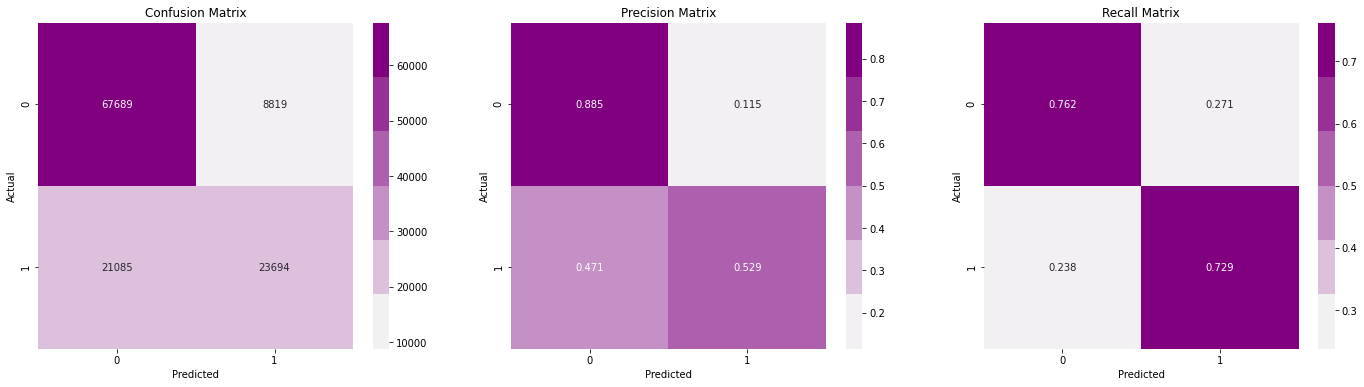

In [34]:
# Finding best alpha
best_alpha = alpha[np.argmin(l2_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='log', alpha=best_alpha, penalty='l2', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_2_train, train_labels)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_2_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_2_train)
predict_test = cal_clf.predict_proba(model_2_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Naive Bayes

### GDBT: XgBoost

#### Hyperparameter tuning

In [35]:
# First, we create the list of hyperparameters to iterate over
max_depth = [2, 4, 6]
n_estimators = [10, 100, 500]

# Initialize list to store log-loss results
result_logloss = []

# Iterating over max_depth
for depth in max_depth:
  # Initialize list to store log loss for this iteration
  logloss = []
  # Iterate over n_estimators
  for n in n_estimators:
    print('Running at depth: {}, n_estimators: {}'.format(depth, n))

    # Initialize model
    gbdt_clf = xgb.XGBClassifier(max_depth=depth, n_estimators=n, objective='binary:logistic', n_jobs=-1, random_state=42)

    # Fitting on train data
    gbdt_clf.fit(model_2_train, train_labels)

    # Initializing calibration model
    cal_clf = CalibratedClassifierCV(gbdt_clf) 

    # Fitting calibration model
    cal_clf.fit(model_2_train, train_labels)

    # Predict on test data
    pred_prob = cal_clf.predict_proba(model_2_test)

    # Get log-loss on predictions
    loss = (log_loss(test_labels, pred_prob))
    logloss.append(loss)

  result_logloss.append(logloss)

Running at depth: 2, n_estimators: 10
Running at depth: 2, n_estimators: 100
Running at depth: 2, n_estimators: 500
Running at depth: 4, n_estimators: 10
Running at depth: 4, n_estimators: 100
Running at depth: 4, n_estimators: 500
Running at depth: 6, n_estimators: 10
Running at depth: 6, n_estimators: 100
Running at depth: 6, n_estimators: 500


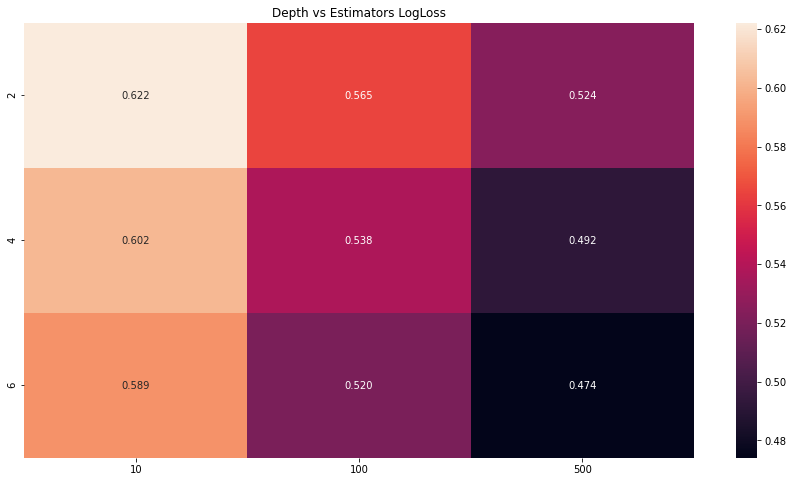

In [36]:
# Plot log loss heatmap
plt.figure(figsize=(15,8))
sns.heatmap(result_logloss, annot=True, fmt='.3f', xticklabels=n_estimators, yticklabels=max_depth)
plt.title('Depth vs Estimators LogLoss')

plt.show()

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.4248268415142206
Log loss for best alpha on test data: 0.47405539227494126




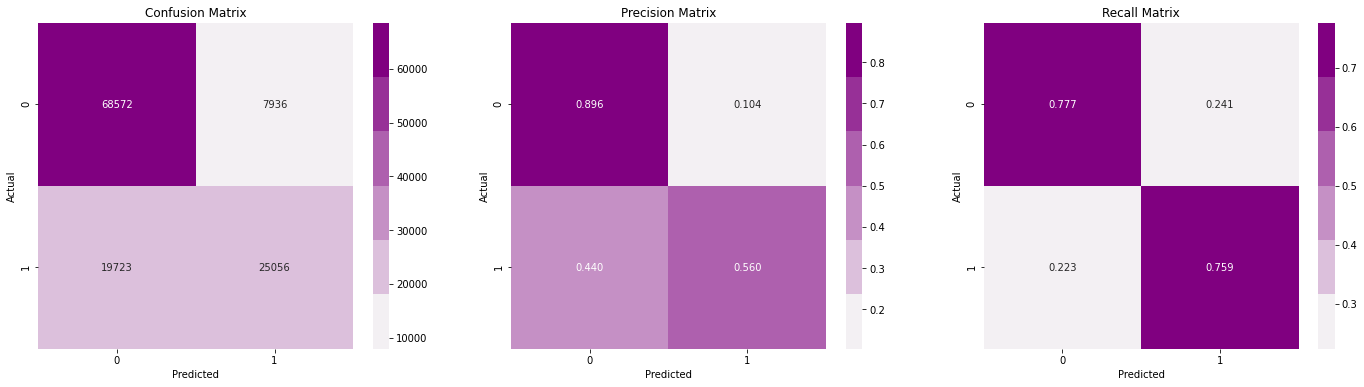

In [37]:
# Setting best hyperparameters
n_estimators = 500 
max_depth = 6

# Initialize model
gbdt_clf = xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, objective='binary:logistic', n_jobs=-1, random_state=42)

# Fitting on train data
gbdt_clf.fit(model_2_train, train_labels)

# Initializing calibration model
cal_clf = CalibratedClassifierCV(gbdt_clf) 

# Fitting calibration model
cal_clf.fit(model_2_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_2_train)
predict_test = cal_clf.predict_proba(model_2_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

## Model 3 : Using BERT Word Embeddings

In [2]:
q1_embeddings_train = pd.read_csv("q1_embeddings_train.csv")
q2_embeddings_train = pd.read_csv("q2_embeddings_train.csv")

q1_embeddings_test = pd.read_csv('q1_embeddings_test.csv')
q2_embeddings_test = pd.read_csv('q2_embeddings_test.csv')

embeddings_train_labels = np.load('embeddings_train_labels.npy')
embeddings_test_labels = np.load('embeddings_test_labels.npy')

In [3]:
q1_embeddings_train.drop('Unnamed: 0', axis=1, inplace=True)
q2_embeddings_train.drop('Unnamed: 0', axis=1, inplace=True)

q1_embeddings_test.drop('Unnamed: 0', axis=1, inplace=True)
q2_embeddings_test.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
# We already loaded the train and test question pair embedding vectors from disk
# Let's horizontally stack them in q1q2 order
model_3_train = np.column_stack((q1_embeddings_train, q2_embeddings_train))
model_3_test = np.column_stack((q1_embeddings_test, q2_embeddings_test))

### Random model
Let's build a random model and check our log-loss and confusion matrices. This can be a baseline for our other models.

In [5]:
# Initialzing data structure to hold predicted probabilities
predicted = np.zeros((len(test_labels), 2))

for i in range(len(test_labels)):
  # Getting 2 random values
  prob = np.random.rand(1, 2)

  # Making so that both the random values sum to 1
  predicted[i] = (prob / sum(sum(prob)))[0]

# Log-loss on the positive class label
random_logloss = log_loss(test_labels, predicted[:, 1])
print('Log-loss for a random model is: {:.5f}\n'.format(random_logloss))

# Now we assign class labels 0 or 1 depending on which has higher probabilities
# This way we can create confusion matrices
predicted = np.argmax(predicted, axis=1)
plot_confusion_matrices(test_labels, predicted)

NameError: name 'test_labels' is not defined

### Logistic Regression

#### Hyperparameter tuning

In [ ]:
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_train, embeddings_train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_train, embeddings_train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_test)

  # Get log-loss on predictions
  loss = (log_loss(embeddings_test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_train, embeddings_train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_train, embeddings_train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_test)

  # Get log-loss on predictions
  loss = (log_loss(embeddings_test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_train, embeddings_train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_train, embeddings_train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_test)

  # Get log-loss on predictions
  loss = (log_loss(embeddings_test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.5430804305157337


The least logloss is from L2 with a loss of 0.535. This is higher than our previous two models. Nevertheless, in this case, we will go with the model which gives a lower loss and therefore proceed with the L2 model.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.4803686999498436
Log loss for best alpha on test data: 0.5171603243778986




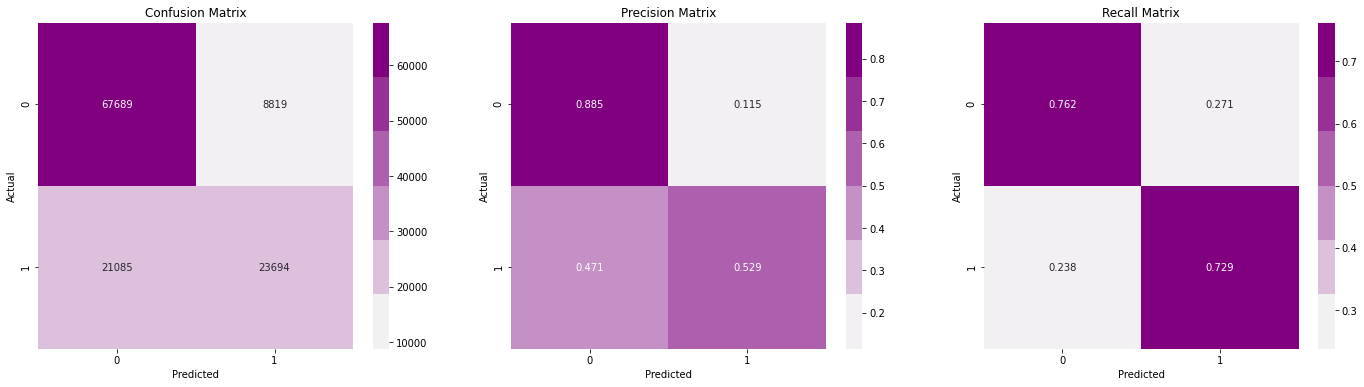

In [34]:
# Finding best alpha
best_alpha = alpha[np.argmin(l2_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='log', alpha=best_alpha, penalty='l2', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_3_train, embeddings_train_labels)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_3_train, embeddings_train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_3_train)
predict_test = cal_clf.predict_proba(model_3_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(embeddings_train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(embeddings_test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(embeddings_test_labels, predicted)

### Naive Bayes

In [ ]:
MultinomialNB

### GDBT: XgBoost

#### Hyperparameter tuning

In [ ]:
# First, we create the list of hyperparameters to iterate over
max_depth = [2, 4, 6]
n_estimators = [10, 100, 500]

# Initialize list to store log-loss results
result_logloss = []

# Iterating over max_depth
for depth in max_depth:
  # Initialize list to store log loss for this iteration
  logloss = []
  # Iterate over n_estimators
  for n in n_estimators:
    print('Running at depth: {}, n_estimators: {}'.format(depth, n))

    # Initialize model
    gbdt_clf = xgb.XGBClassifier(max_depth=depth, n_estimators=n, objective='binary:logistic', n_jobs=-1, random_state=42)

    # Fitting on train data
    gbdt_clf.fit(model_3_train, embeddings_train_labels)

    # Initializing calibration model
    cal_clf = CalibratedClassifierCV(gbdt_clf) 

    # Fitting calibration model
    cal_clf.fit(model_3_train, embeddings_train_labels)

    # Predict on test data
    pred_prob = cal_clf.predict_proba(model_3_test)

    # Get log-loss on predictions
    loss = (log_loss(embeddings_test_labels, pred_prob))
    logloss.append(loss)

  result_logloss.append(logloss)

Running at depth: 2, n_estimators: 10
[12:15:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:16:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:17:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:34] WARNING: C:/Users/Adm

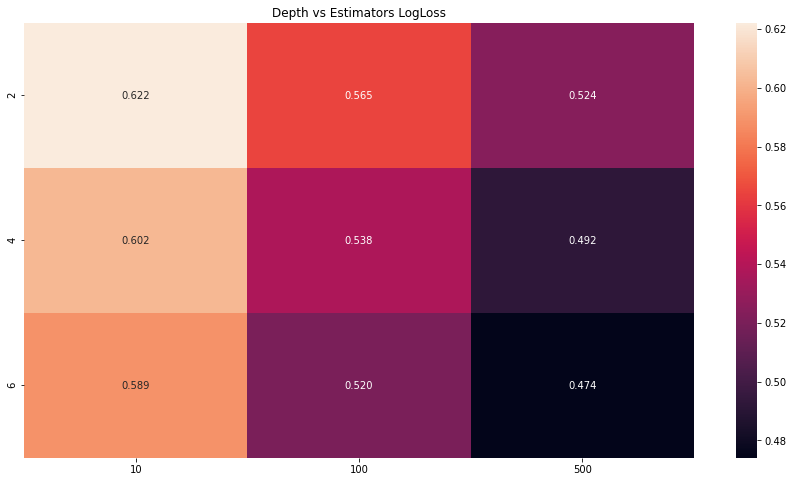

In [36]:
# Plot log loss heatmap
plt.figure(figsize=(15,8))
sns.heatmap(result_logloss, annot=True, fmt='.3f', xticklabels=n_estimators, yticklabels=max_depth)
plt.title('Depth vs Estimators LogLoss')

plt.show()

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.4248268415142206
Log loss for best alpha on test data: 0.47405539227494126




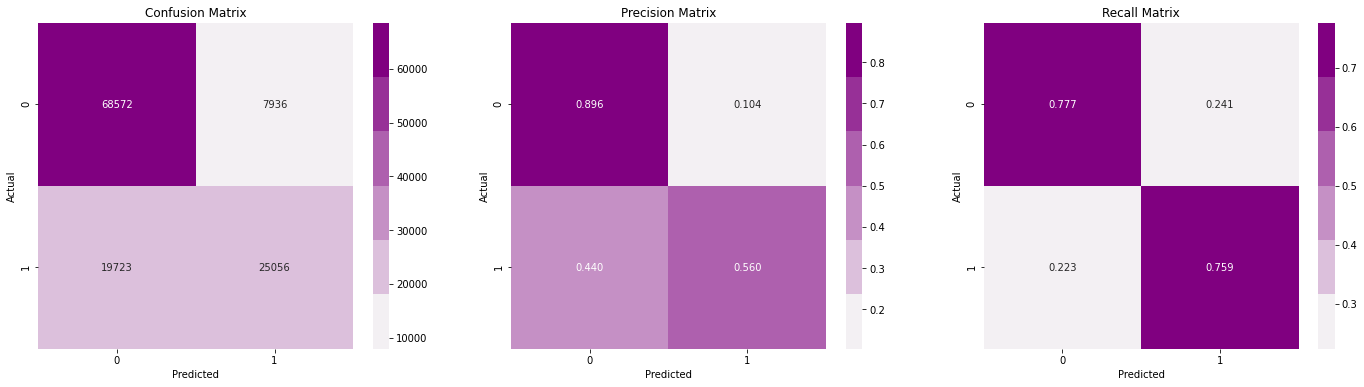

In [37]:
# Setting best hyperparameters
n_estimators = 500 
max_depth = 6

# Initialize model
gbdt_clf = xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, objective='binary:logistic', n_jobs=-1, random_state=42)

# Fitting on train data
gbdt_clf.fit(model_3_train, embeddings_train_labels)

# Initializing calibration model
cal_clf = CalibratedClassifierCV(gbdt_clf) 

# Fitting calibration model
cal_clf.fit(model_3_train, embeddings_train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_3_train)
predict_test = cal_clf.predict_proba(model_3_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(embeddings_train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(embeddings_test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(embeddings_test_labels, predicted)

## Model with RoBERT Embeddings